# Demo de implementación de un algoritmo de Colonia de Abejas (Bee Algorithm) para resolver el problema de encontrar un Máximo Óptimo  definido al azar en un plano y tratando de esquivar  los máximos locales aleatorios


1) Importar librerías:

In [0]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import operator
print("\nLibrerías importadas")


Librerías importadas


2) Establecer parámetros generales de la Corrida:

In [0]:
# Cantidad de Máximos Locales
CANT_MAXIMOS_LOCALES = 3

# Espacio mínimo y máximp del espacio de búsqueda
MIN_ESPACIO_BUSQ = -1000
MAX_ESPACIO_BUSQ = 1000

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100

# Cantidades para  Abejas Exploradoras
CANT_ABEJAS_EXPLORADORAS = 5
CANT_MEJORES_ABEJAS_RECLUTAN = 5
CANT_ABEJAS_OBRERAS_RECL_ELITE = 2
CANT_ABEJAS_OBRERAS_RECL_NORMAL = 1

#  Área de las Abejas Exploradoras
RADIO_AREA_EXPLORADORA = 50
PORC_RED_AREA_EXPLORADORA = 0.5
MIN_RADIO_AREA_EXPLORADORA = 2

# Indica si se muestra el detalle de cada ciclo
MUESTRA_DETALLE = True

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


3) Especificar el objeto Abeja y la Función Heurística:

In [0]:
### FUNCIÓN HEURÍSTICA

# Define Posiciones Random para Máximos Locales y Óptimos
# con Heurística también al Azar (entre -10 y 100)
POS_RANDOM_EVALUAR = []
VAL_RANDOM_EVALUAR = []
POS_RANDOM_EVALUAR_OPTIMO = 0
auxMejorVal = -99
print("** Posiciones Generadas al Azar: **")
for i in range(CANT_MAXIMOS_LOCALES+1):

    auxPos = ( round(random.uniform(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ),3),  round(random.uniform(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ),3) ) 
    auxVal = int(random.uniform(-10, 100))

    POS_RANDOM_EVALUAR.append( auxPos )
    VAL_RANDOM_EVALUAR.append( auxVal )
    
    print(" -->", auxPos, "{ ", auxVal, "} ")

    if VAL_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO] < auxVal:
        POS_RANDOM_EVALUAR_OPTIMO = i

print("** Posición Máximo Óptimo a Buscar: ", POS_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO], " { ",  VAL_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO]," } **")

# Definimos la función a evaluar
def funcHeuristica(abeja):

    devuelve = -100
    disPosMenor = MAX_ESPACIO_BUSQ
    for posi, vali in zip(POS_RANDOM_EVALUAR, VAL_RANDOM_EVALUAR):

          # calcula la distancia al punto de la Particula
          sqerrors = ((x - y)**2 for x, y in zip(abeja.posicion, posi))
          distPos =  math.fsum(sqerrors)**0.5 / 10
          
          # Si es la menor distancia calcula la Heurística
          if disPosMenor > distPos:
              disPosMenor = distPos 
              devuelve = ( vali - distPos) 

    return devuelve

print("\nFunción Heurística definida")

** Posiciones Generadas al Azar: **
 --> (677.622, -944.7) {  20 } 
 --> (-422.263, 785.836) {  15 } 
 --> (740.449, -809.778) {  71 } 
 --> (411.24, -337.9) {  81 } 
** Posición Máximo Óptimo a Buscar:  (411.24, -337.9)  {  81  } **

Función Heurística definida


In [0]:
# clase ABEJA
class Abeja(object):

    
    def __init__(self, pmin=0, pmax=0, radioArea=0):
        
        if pmin==0 and pmax==0:
            self.pos = []
            self.radio = 0
            self.valor = -9999
        else:        
            self.pos = [random.uniform(pmin, pmax) for _ in range(2)]
            self.valor = funcHeuristica(self)
            self.radio = radioArea

    def _reset(self):
        pos = []
        radio = 0
        valor = -9999

    @property
    def heuristica(self):
        return self.valor

    @property
    def posicion(self):
        return self.pos    

    @property
    def tieneArea(self):
        return self.radio>0 

    def reclutarObreras(self, cantObrerasReclutadas):
        
        # Si el radio del área es nulo, no se generan
        if self.radio <= 0:
            return []

        obrerasReclutadasNuevas = []
        algunaObreraMejor = False
        for i in range(cantObrerasReclutadas):

              # Crea una nueva abeja a la que le asigna una posción relativa a la exploradora padre
              # y luego calcula su herística
              nOb = Abeja()
              for i in range(len(self.pos)):
                  nOb.pos.append( random.uniform(self.pos[i]-self.radio, self.pos[i]+self.radio) )
              nOb.valor = funcHeuristica(nOb)
              
              if nOb.valor > self.valor:
                  # si la nueva obra es mejor que la padre, 
                  #    pasa a ser una exploradora
                  nOb.radio = RADIO_AREA_EXPLORADORA
                  algunaObreraMejor = True

              obrerasReclutadasNuevas.append( nOb )
        
        if not algunaObreraMejor:
                # Cuando ninguna obrera es mejor, 
                #     se reduce el área de la abeja exploradora 
                self.radio = self.radio * (1-PORC_RED_AREA_EXPLORADORA)
                if self.radio <= MIN_RADIO_AREA_EXPLORADORA:
                    self.radio = 0

        return obrerasReclutadasNuevas

    def hacerExploradoraArea(self, radioArea):
        self.radio = radioArea
        return self.radioArea

print("\nClase Abeja definida")


Clase Abeja definida


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [0]:
## EJECUCIÓN DE LA CORRIDA

# vectores auxiliares 
ciclo = 1    
mejorAbeja = None
mejorAbejaCorrida = None
ciclosAbejas = []
ciclosMaxAptitud = []
beePobla = []

# Define las abejas exploradoras iniciales
for i in range(CANT_ABEJAS_EXPLORADORAS):
  b = Abeja(pmin=MIN_ESPACIO_BUSQ, pmax=MAX_ESPACIO_BUSQ, radioArea=RADIO_AREA_EXPLORADORA)
  beePobla.append( b ) 
  ciclosAbejas.append( b.posicion )

while ciclo < CANT_CICLOS:

    if MUESTRA_DETALLE:
        print("\n-- Ciclo  %i --" % ciclo)    
        print("  Cantidad de Abejas: ", len(beePobla) ) 

    # Evalúa las abejas exploradoras de la población para determinar las mejores con área disponible
    rankingAbejas = sorted([b for b in beePobla if b.tieneArea], key=operator.attrgetter('heuristica'), reverse=True)
    mejorAbeja = rankingAbejas[0]
    if mejorAbejaCorrida == None or mejorAbeja.heuristica > mejorAbejaCorrida.heuristica:
        mejorAbejaCorrida = mejorAbeja
    ciclosMaxAptitud.append( rankingAbejas[0].heuristica )

    # Realiza la reclutación de las abejas
    # pero  solo de las 'CANT_MEJORES_ABEJAS_RECLUTAN' mejores
    reclObreras = []
    for exBee in rankingAbejas[:CANT_MEJORES_ABEJAS_RECLUTAN]:
          # Recluta las abejas obreras (cantidad elite para la mejor, normal el resto)
          if exBee == mejorAbeja:
              reclObreras = exBee.reclutarObreras(CANT_ABEJAS_OBRERAS_RECL_ELITE)
          else:
              reclObreras = exBee.reclutarObreras(CANT_ABEJAS_OBRERAS_RECL_NORMAL)

          # Agrega las nuevas abejas reclutadas
          beePobla.extend( reclObreras )
          ciclosAbejas.extend([b.posicion for b in reclObreras])

    if MUESTRA_DETALLE:
        print("  Mejor Abeja:", mejorAbeja.posicion, " ( ", mejorAbeja.heuristica, " ) ")

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )
print("** Posición Máximo Óptimo a Buscar: ", POS_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO], " { ",  VAL_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO]," } **")
print("== Mejor Abeja de la Corrida:", mejorAbejaCorrida.posicion, " { ", mejorAbejaCorrida.heuristica, " } ==")


-- Ciclo  1 --
  Cantidad de Abejas:  5
  Mejor Abeja: [-4.197376712013124, -271.62542079184357]  (  38.930945599101314  ) 

-- Ciclo  2 --
  Cantidad de Abejas:  11
  Mejor Abeja: [-4.197376712013124, -271.62542079184357]  (  38.930945599101314  ) 

-- Ciclo  3 --
  Cantidad de Abejas:  17
  Mejor Abeja: [10.701202609443428, -292.7653783272265]  (  40.69262321998394  ) 

-- Ciclo  4 --
  Cantidad de Abejas:  23
  Mejor Abeja: [38.05251053248153, -271.30752783522246]  (  43.09176083697821  ) 

-- Ciclo  5 --
  Cantidad de Abejas:  29
  Mejor Abeja: [85.73022089597293, -299.08426872107157]  (  48.21840801805524  ) 

-- Ciclo  6 --
  Cantidad de Abejas:  35
  Mejor Abeja: [135.50331037158833, -336.33556386655056]  (  53.42588723682108  ) 

-- Ciclo  7 --
  Cantidad de Abejas:  41
  Mejor Abeja: [174.08427703425534, -303.396680969097]  (  57.03475100076085  ) 

-- Ciclo  8 --
  Cantidad de Abejas:  47
  Mejor Abeja: [204.66555473979787, -311.6417406684931]  (  60.17633614906327  ) 

-- C

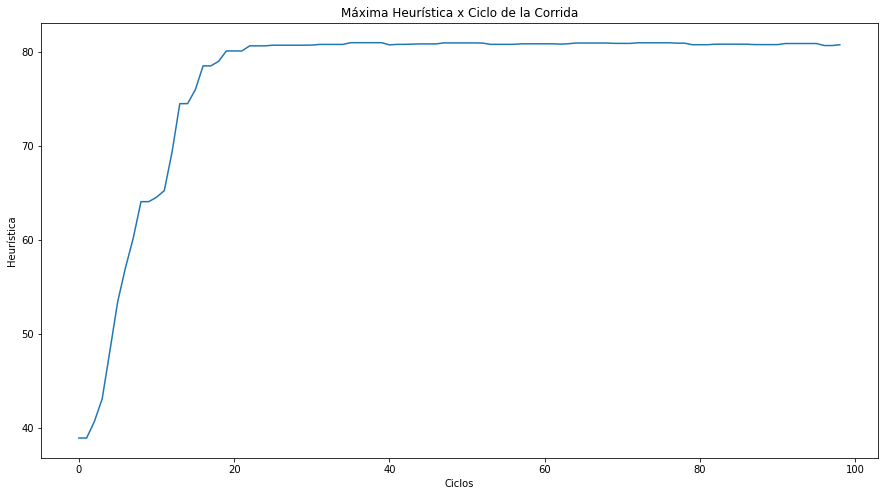

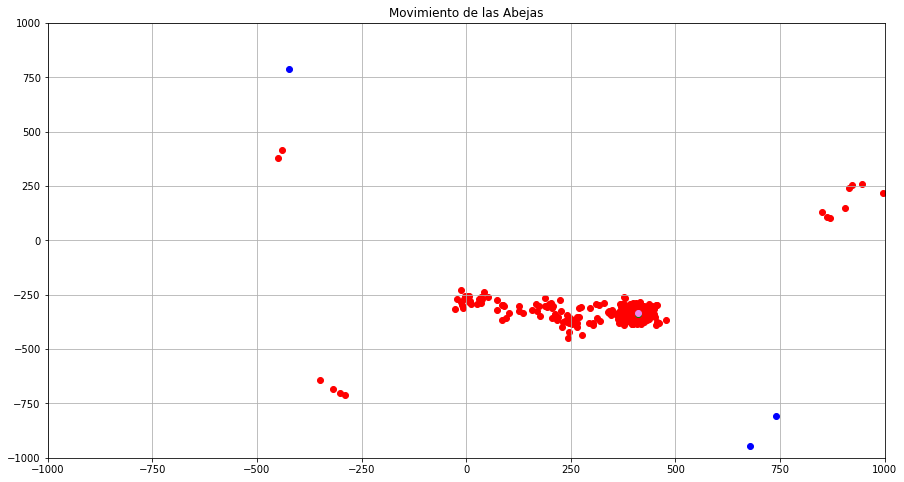

In [0]:
## MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosMaxAptitud)
plt.title('Máxima Heurística x Ciclo de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Heurística')
plt.show()

## MOSTRAR GRAFICO DEL MOVIMIENTO DE LAS ABEJAS
plt.figure(figsize=(15,8)) 

## --en Rojo: posiciones de las ABEJASde cada ciclo
for bee in ciclosAbejas:
  plt.scatter(bee[0], bee[1], color='red')

## -- en Azul: Máximos Locales (positivos)
## -- en Cyan: Mínimos Locales (negativos)
## -- en Verde: Máximo Óptimo
for posi, vali in zip(POS_RANDOM_EVALUAR, VAL_RANDOM_EVALUAR):
  if posi == POS_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO]:
      plt.scatter(posi[0], posi[1], color='green')
  elif vali < 0:
      plt.scatter(posi[0], posi[1], color='cyan')
  else:
      plt.scatter(posi[0], posi[1], color='blue')

## --en Violeta: Mejor posición de las partículas
plt.scatter(mejorAbeja.posicion[0], mejorAbeja.posicion[1], color='violet')

plt.title('Movimiento de las Abejas')
plt.xlim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
plt.ylim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
plt.grid(True)
plt.show()
